In [4]:
pd.set_option('display.max_colwidth', 100)
from copy import deepcopy
from scipy.stats.mstats import mquantiles
from chase.cpt import *
from chase.drift import *
from chase.base import *
from chase.utils import *
from chase.fit import *
from mypy.explib.technion import technion
import itertools
from scipy.stats import pearsonr

def pmatch(pair):
    observed, predicted = pair
    
    if observed == 0.5 or predicted == 0.5:
        return 0.5
    elif (observed < 0.5 and predicted < 0.5) or (observed > 0.5 and predicted > 0.5):
        return 1
    else:
        return 0

FIGDEST = '/Users/markant/code/chase/chase/paper/results_figures'
TABDEST = '/Users/markant/code/chase/chase/paper/results_tables'
OUTDIR = 'results_fits/chase_fitresults_tpt'


# number of iterations for each parameter set
N_ITER = 2

# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 7],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 5, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],
        'sc': [0, 1, 1],
        'p_stop': [0, 1, .5]}

PARSETS = {}
PARSETS['optional'] = [['theta', 'p_stay', 'tau'],
                       ['theta', 'p_stay', 'tau', 'prelec_gamma'],
                       ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                       ['theta', 'p_stay', 'tau', 'pow_gain'],
                       #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                       ]

PARSETS['geometric'] = [['p_stop', 'p_stay', 'tau'],
                        ['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                        ['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                        ['p_stop', 'p_stay', 'tau', 'pow_gain'],
                        #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                        ]

FIXED = {}
for pref_units in ['sums', 'diffs']:
    FIXED[('optional',pref_units)] = {'c': 0.5,
                                      'minsamplesize': 2,
                                      'pref_units': pref_units,
                                      'stoprule': 'optional'}

    FIXED[('geometric',pref_units)] = {'c': 0.5,
                                       'minsamplesize': 2,
                                       'pref_units': pref_units,
                                       'stoprule': 'geometric',
                                       'theta': 30}
    
cp = {}
bf_cp = {}
bf_par = {}
msd_cp = {}
quant = {}
bf_quant = {}

cp_asc = {}
bf_cp_asc = {}

In [ ]:
m = CHASEModel(drift='cpt',
               startdist='laplace',
               problems=problems)
pars = {'theta': 2,
        'p_stay': 0.3,
        'tau': 1,
        'prelec_gamma': 1.4,
        'minsamplesize': 2,
        'sc': .1,
        'c': .5}

drifts = [m.drift(problems[pid], pars) for pid in problems_srt]

In [ ]:
cp = np.array([data[data.problem==i].choice.mean() for i in problems_srt])
plt.plot(drifts)
plt.plot(cp - .5)

# Load data for estimation set

In [2]:
technion.load_data('est')
problems = {(gid-1): technion.get_options(gid) for gid in technion.problems}
problems_srt = technion.problems_srt - 1

data = pd.read_csv('data/tpt/tpt_data_est.csv', index_col=0)
data['group'] = 0

SIM_ID = 'tpt_est'

# Fit estimation set

In [ ]:
for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
    
    print '[%s, %s]\nsaving results to %s' % (stoprule, pref_units, OUTDIR)
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
    
    if stoprule == 'optional':      model = CHASEModel
    elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
        
    for parset in P:

        fitting = {p: PARS[p] for p in parset}

        m = model(drift='cpt',
                  startdist='laplace',
                  problems=problems,
                  stoprule=stoprule)

        # fit
        results = fit_mlh(m, problems, data, SIM_ID, F, fitting, 
                          niter=N_ITER, outdir=OUTDIR)

        print results.sort('nllh')

In [6]:
# create a table summarizing the best-fitting result for each parameter
# combination
allresults = pd.DataFrame(columns=['sim_id', 'stoprule', 'pref_units', 'k', 'N', 'nllh', 'bic'])

for stoprule, pref_units in itertools.product(['optional', 'geometric'], ['diffs', 'sums']):
    
    P = PARSETS[stoprule]
    F = FIXED[(stoprule,pref_units)]
            
    for parset in P:
        fitting = {p: PARS[p] for p in parset}
        b = best_result(SIM_ID, F, fitting, outdir=OUTDIR, nopars=True)
        b['stoprule'] = stoprule
        b['pref_units'] = pref_units
        allresults.loc[allresults.shape[0]] = b

allresults.sort_values(by='bic', inplace=True)
allresults.to_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID))

In [7]:
allresults = pd.read_csv('%s/%s_fitsummary.csv' % (TABDEST, SIM_ID), index_col=0)
allresults

,sim_id,stoprule,pref_units,k,N,nllh,bic
1,"tpt_est(p_stay,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=diffs,stoprule=optional)",optional,diffs,4.0,1170.0,4570.993316,9170.245667
2,"tpt_est(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=diffs,st...",optional,diffs,5.0,1170.0,4570.159830,9175.643456
9,"tpt_est(p_stay,p_stop,prelec_gamma,tau|c=0.5,minsamplesize=2,pref_units=diffs,stoprule=geometric...",geometric,diffs,4.0,1170.0,4584.403792,9197.066621
10,"tpt_est(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|c=0.5,minsamplesize=2,pref_units=diffs,s...",geometric,diffs,5.0,1170.0,4596.791732,9228.907260
5,"tpt_est(p_stay,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,stoprule=optional)",optional,sums,4.0,1170.0,4607.787119,9243.833274
6,"tpt_est(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,minsamplesize=2,pref_units=sums,sto...",optional,sums,5.0,1170.0,4607.513280,9250.350356
13,"tpt_est(p_stay,p_stop,prelec_gamma,tau|c=0.5,minsamplesize=2,pref_units=sums,stoprule=geometric,...",geometric,sums,4.0,1170.0,4617.477129,9263.213294
3,"tpt_est(p_stay,pow_gain,tau,theta|c=0.5,minsamplesize=2,pref_units=diffs,stoprule=optional)",optional,diffs,4.0,1170.0,4622.387434,9273.033904
0,"tpt_est(p_stay,tau,theta|c=0.5,minsamplesize=2,pref_units=diffs,stoprule=optional)",optional,diffs,3.0,1170.0,4629.845344,9280.884964
14,"tpt_est(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|c=0.5,minsamplesize=2,pref_units=sums,st...",geometric,sums,5.0,1170.0,4625.283163,9285.890121


In [9]:
# setup a selected model to show results
stoprule = 'optional'
pref_units = 'diffs'
parset = PARSETS[stoprule][2]
F = FIXED[(stoprule,pref_units)]
fitting = {p: PARS[p] for p in parset}
r = best_result(SIM_ID, F, fitting, outdir=OUTDIR)
bf_par[SIM_ID] = {p: r[p] for p in fitting}

In [10]:
# for the selected model, run the model and get the 
# predicted choice proportions and sample size distribution
if stoprule == 'optional':      model = CHASEModel
elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
m = model(drift='cpt',
          startdist='laplace',
          problems=problems,
          stoprule=stoprule)


#m = CHASEModel(drift='cpt', startdist='laplace')
pred = predict_from_result(m, problems, data, SIM_ID, F, 
                           fitting = fitting, 
                           outdir=OUTDIR)

cp[SIM_ID] = np.array([data[data.problem==i].choice.mean() for i in problems_srt])
bf_cp[SIM_ID] = np.array([pred[pred.problem==i].cp.mean() for i in problems_srt])

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean(axis=0).values #+ 2

msd_cp[SIM_ID] = np.round(((cp[SIM_ID] - bf_cp[SIM_ID])**2).mean(), 3)
print 'MSD: %s' % msd_cp[SIM_ID]

MSD: 0.017


/Users/markant/code/chase/chase/base.py:105: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  S[i] = np.dot(S[i-1], Q)


In [13]:
problems_srt_cp = np.array((problems_srt[:20][cp['tpt_est'][:20].argsort()],
          problems_srt[20:40][cp['tpt_est'][20:40].argsort()],
          problems_srt[40:][cp['tpt_est'][40:].argsort()])).ravel()

cp_asc[SIM_ID] = np.array([data[data.problem==i].choice.mean() for i in problems_srt_cp])
bf_cp_asc[SIM_ID] = pred.groupby('problem').apply(lambda d: d.cp.mean()).loc[problems_srt_cp].values

In [14]:
observed = cp[SIM_ID]
predicted = bf_cp[SIM_ID]
pagree = np.sum(map(pmatch, zip(observed, predicted))) / float(len(observed))
tmp = filter(lambda pair: pair[0] != 0.5, zip(observed, predicted))
pagree_corr = np.sum(map(pmatch, tmp)) / float(len(tmp))

msd = np.round(np.mean((observed - predicted) ** 2), 4)
rcorr = np.round(pearsonr(observed, predicted)[0], 4)

tot_ss = np.sum((observed - np.mean(observed)) ** 2)
res_ss = np.sum((observed - predicted) ** 2)
r_sq = 1 - (res_ss / tot_ss)

print 'p(agree):\t', pagree
print 'p(agree)2:\t', pagree_corr
print 'r:\t\t', rcorr
print 'msd:\t\t', msd
print 'R2:\t\t', r_sq

p(agree):	0.925
p(agree)2:	0.932203389831
r:		0.8871
msd:		0.0171
R2:		0.682870971744


# Predictions for competition dataset

In [16]:
technion.load_data('comp')
problems_comp = {(gid-1): technion.get_options(gid) for gid in technion.problems}
problems_comp_srt = technion.problems_srt - 1

data = pd.read_csv('data/tpt/tpt_data_comp.csv', index_col=0)
data['group'] = 0
data['problem'] = data['problem'] - 1

In [17]:
if stoprule == 'optional':      model = CHASEModel
elif stoprule == 'geometric':   model = CHASEAlternateStoppingModel
m = model(drift='cpt',
          startdist='laplace',
          problems=problems_comp,
          stoprule=stoprule)

pred = predict_from_result(m, problems_comp, data, SIM_ID, F, 
                           fitting = fitting, 
                           outdir=OUTDIR)

#m = CHASEModel(drift='cpt', startdist='laplace', problems=problems_comp)
#pred = predict_from_result(m, problems_comp, data, SIM_ID, FIXED, fitting=fitting, 
#                           outdir=OUTDIR)

cp['tpt_comp'] = np.array([data[data.problem==i].choice.mean() for i in problems_comp_srt])
bf_cp['tpt_comp'] = np.array([pred[pred.problem==i].cp.mean() for i in problems_comp_srt])

quant['tpt_comp'] = mquantiles(data.samplesize)
bf_quant['tpt_comp'] = pred[['ss(.25)', 'ss(.5)', 'ss(.75)']].mean(axis=0).values #+ 2

print quant['tpt_comp']
print bf_quant['tpt_comp']

[  6.  11.  20.]
[  4.    8.2  15.1]


In [19]:
problems_comp_srt_cp = np.array((problems_comp_srt[:20][cp['tpt_comp'][:20].argsort()],
          problems_comp_srt[20:40][cp['tpt_comp'][20:40].argsort()],
          problems_comp_srt[40:][cp['tpt_comp'][40:].argsort()])).ravel()

cp_asc['tpt_comp'] = np.array([data[data.problem==i].choice.mean() for i in problems_comp_srt_cp])
bf_cp_asc['tpt_comp'] = pred.groupby('problem').apply(lambda d: d.cp.mean()).loc[problems_comp_srt_cp].values

In [20]:
observed = cp['tpt_comp']
predicted = bf_cp['tpt_comp']

pagree = np.sum(map(pmatch, zip(observed, predicted))) / float(len(observed))
tmp = filter(lambda pair: pair[0] != 0.5, zip(observed, predicted))
pagree_corr = np.sum(map(pmatch, tmp)) / float(len(tmp))

msd = np.round(np.mean((observed - predicted) ** 2), 4)
rcorr = np.round(pearsonr(observed, predicted)[0], 4)

tot_ss = np.sum((observed - np.mean(observed)) ** 2)
res_ss = np.sum((observed - predicted) ** 2)
r_sq = 1 - (res_ss / tot_ss)

print 'p(agree):\t', pagree
print 'p(agree)2:\t', pagree_corr
print 'r:\t\t', rcorr
print 'msd:\t\t', msd
print 'R2:\t\t', r_sq

p(agree):	0.883333333333
p(agree)2:	0.910714285714
r:		0.6658
msd:		0.0233
R2:		0.427369102588


# Combine results

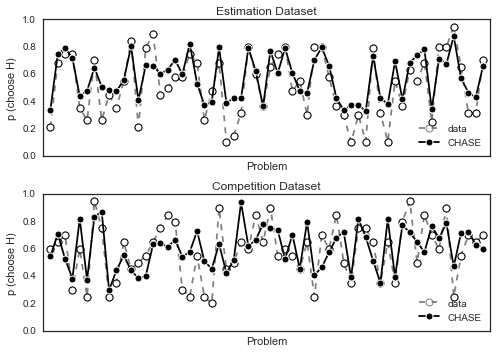

In [21]:
labels = ['Estimation Dataset', 'Competition Dataset']
col = ['black', 'black']

fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
for i, study in enumerate(['tpt_est', 'tpt_comp']):
    axi = ax[i]
    axi.plot(range(1, 61), cp[study], '--o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 61), cp[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 61), bf_cp[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 61)
    axi.set_xticks([])
    axi.set_xlabel('Problem')
    axi.set_ylabel('p (choose H)')
    axi.set_title(labels[i])
    axi.legend(loc='lower right')
plt.tight_layout()
plt.show()
#fig.savefig(FIGDEST + 'tpt_choiceprop.pdf', bbox_inches='tight')

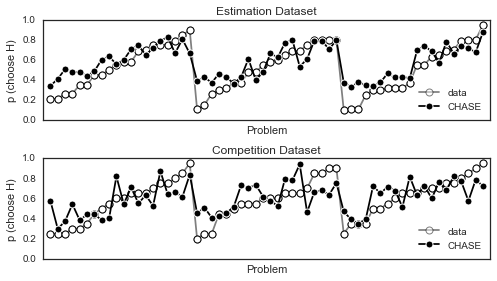

In [23]:
labels = ['Estimation Dataset', 'Competition Dataset']
col = ['black', 'black']

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
for i, study in enumerate(['tpt_est', 'tpt_comp']):
    axi = ax[i]
    axi.plot(range(1, 61), cp_asc[study], '-o', markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, color=col[i], alpha=.5,
             label='data')

    # hacky
    axi.plot(range(1, 61), cp_asc[study], 'o', markerfacecolor='white', markeredgecolor=col[i],
             markeredgewidth=1)


    axi.plot(range(1, 61), bf_cp_asc[study], '-o', markerfacecolor=col[i], markeredgecolor='white', 
             markeredgewidth=1, color=col[i], label='CHASE')
    axi.set_ylim(0, 1)
    axi.set_xlim(0, 61)
    axi.set_xticks([])
    axi.set_xlabel('Problem')
    axi.set_ylabel('p (choose H)')
    axi.set_title(labels[i])
    axi.legend(loc='lower right')
    

plt.tight_layout()
plt.show()
fig.savefig('%s/tpt_choiceprop_asc.pdf' % FIGDEST, bbox_inches='tight')

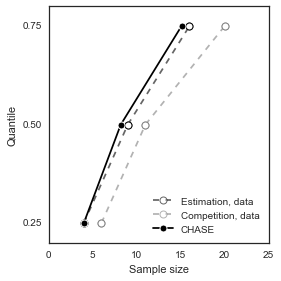

In [24]:
labels = ['Estimation', 'Competition']
col = ['black', 'gray']


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

axi = ax
for i, study in enumerate(['tpt_est', 'tpt_comp']):

    axi.plot(quant[study], [.25, .5, .75], '--o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], 
             markeredgewidth=1, label='%s, data' % labels[i], alpha=.6)
    
    # hacky
    axi.plot(quant[study], [.25, .5, .75], 'o', color=col[i],
             markerfacecolor='white', markeredgecolor=col[i], markeredgewidth=1)

    if i==1:
        axi.plot(bf_quant[study], [.25, .5, .75], '-o', color='black', 
                 markerfacecolor='black', markeredgecolor='white',
                 markeredgewidth=1, label='CHASE')

axi.set_xlim(0, 25)
axi.legend(loc='lower right')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')
axi.set_yticks([.25, .5, .75])

plt.tight_layout()
plt.show()
fig.savefig('%s/tpt_quantiles.pdf' % FIGDEST, bbox_inches='tight')